In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prospect.utils.obsutils import fix_obs
import seaborn as sns
sns.set_context('notebook')

from agnfinder.prospector import visualise, main, cpz_builders

In [3]:
def get_samples(sample_loc, drop=1000):
    assert os.path.isfile(sample_loc)
    with h5py.File(sample_loc, 'r') as f:
        return f['samples'][drop:]

In [4]:
run_dir = '/home/mike/repos/agnfinder/results/qso_fixed_inclination_bigger_agn'

files = os.listdir(run_dir)
sample_files = [x for x in files if 'multinest_samples' in x]

qso_sample_locs = [os.path.join(run_dir, x) for x in sample_files if 'qso_bigger_agn_mass_fixed_inclination' in x]
agn_sample_locs = [os.path.join(run_dir, x) for x in sample_files if 'agn_bigger_agn_mass_fixed_inclination' in x]
starforming_sample_locs = [os.path.join(run_dir, x) for x in sample_files if 'starforming_bigger_agn_mass_fixed_inclination' in x]

assert qso_sample_locs
assert agn_sample_locs
assert starforming_sample_locs

In [5]:
samples_by_class = {
    'qso': qso_sample_locs,
    'agn': agn_sample_locs,
    'starforming': starforming_sample_locs
}

In [6]:
free_params = ['mass', 'dust2', 'tage', 'tau', 'agn_mass', 'agn_eb_v', 'agn_torus_mass']
# WARNING this is hardcoded, will need to change should model change

In [7]:
 samples_by_class['qso']

['/home/mike/repos/agnfinder/results/qso_fixed_inclination_bigger_agn/qso_bigger_agn_mass_fixed_inclination_0_1564527506_multinest_samples.h5py',
 '/home/mike/repos/agnfinder/results/qso_fixed_inclination_bigger_agn/qso_bigger_agn_mass_fixed_inclination_3_1564527518_multinest_samples.h5py',
 '/home/mike/repos/agnfinder/results/qso_fixed_inclination_bigger_agn/qso_bigger_agn_mass_fixed_inclination_8_1564527925_multinest_samples.h5py',
 '/home/mike/repos/agnfinder/results/qso_fixed_inclination_bigger_agn/qso_bigger_agn_mass_fixed_inclination_8_1564527940_multinest_samples.h5py',
 '/home/mike/repos/agnfinder/results/qso_fixed_inclination_bigger_agn/qso_bigger_agn_mass_fixed_inclination_7_1564527732_multinest_samples.h5py',
 '/home/mike/repos/agnfinder/results/qso_fixed_inclination_bigger_agn/qso_bigger_agn_mass_fixed_inclination_5_1564527528_multinest_samples.h5py',
 '/home/mike/repos/agnfinder/results/qso_fixed_inclination_bigger_agn/qso_bigger_agn_mass_fixed_inclination_6_1564527732_mul

In [8]:
galaxy_classes = ['qso', 'agn', 'starforming']

In [9]:
data = []
for galaxy_class in galaxy_classes:
    for sample_loc in samples_by_class[galaxy_class]:
        samples = get_samples(sample_loc)
        temp_df = pd.DataFrame(samples, columns=free_params)
        temp_df['galaxy_class'] = galaxy_class
        data.append(temp_df)
raw_df = pd.concat(data).reset_index()
del data

In [10]:
raw_df.sample(5)

,index,mass,dust2,tage,tau,agn_mass,agn_eb_v,agn_torus_mass,galaxy_class
72325,1862,4.502462e+08,0.052706,4.075711,7.228268,0.088564,0.480934,0.001583,agn
61772,1222,3.868458e+08,0.042724,7.434773,19.291079,0.056832,0.498561,0.001600,agn
77663,2829,2.573890e+08,0.193156,1.233306,0.218100,0.022317,0.472395,0.001030,agn
49399,3106,2.985461e+08,0.132587,1.179378,0.176212,0.015347,0.451778,0.001170,agn
18745,623,3.089845e+09,0.223413,6.659462,2.888578,2.038932,0.068745,0.001485,qso


In [11]:
limits = {
    'mass': [0., 1e11],
    'dust2': [0., 2.],
    'tage': [0., 15.],
    'tau': [0., 6.],
    'agn_mass': [0, 50],
    'agn_eb_v': [0., 0.5],
    'agn_torus_mass': [0., 50]
}

df = raw_df.copy()
for col, lims in limits.items():
    df = df[(df[col] > lims[0]) & (df[col] < lims[1])]


In [12]:
len(df), len(raw_df)

(106701, 135821)

In [13]:
log_params = ['mass']

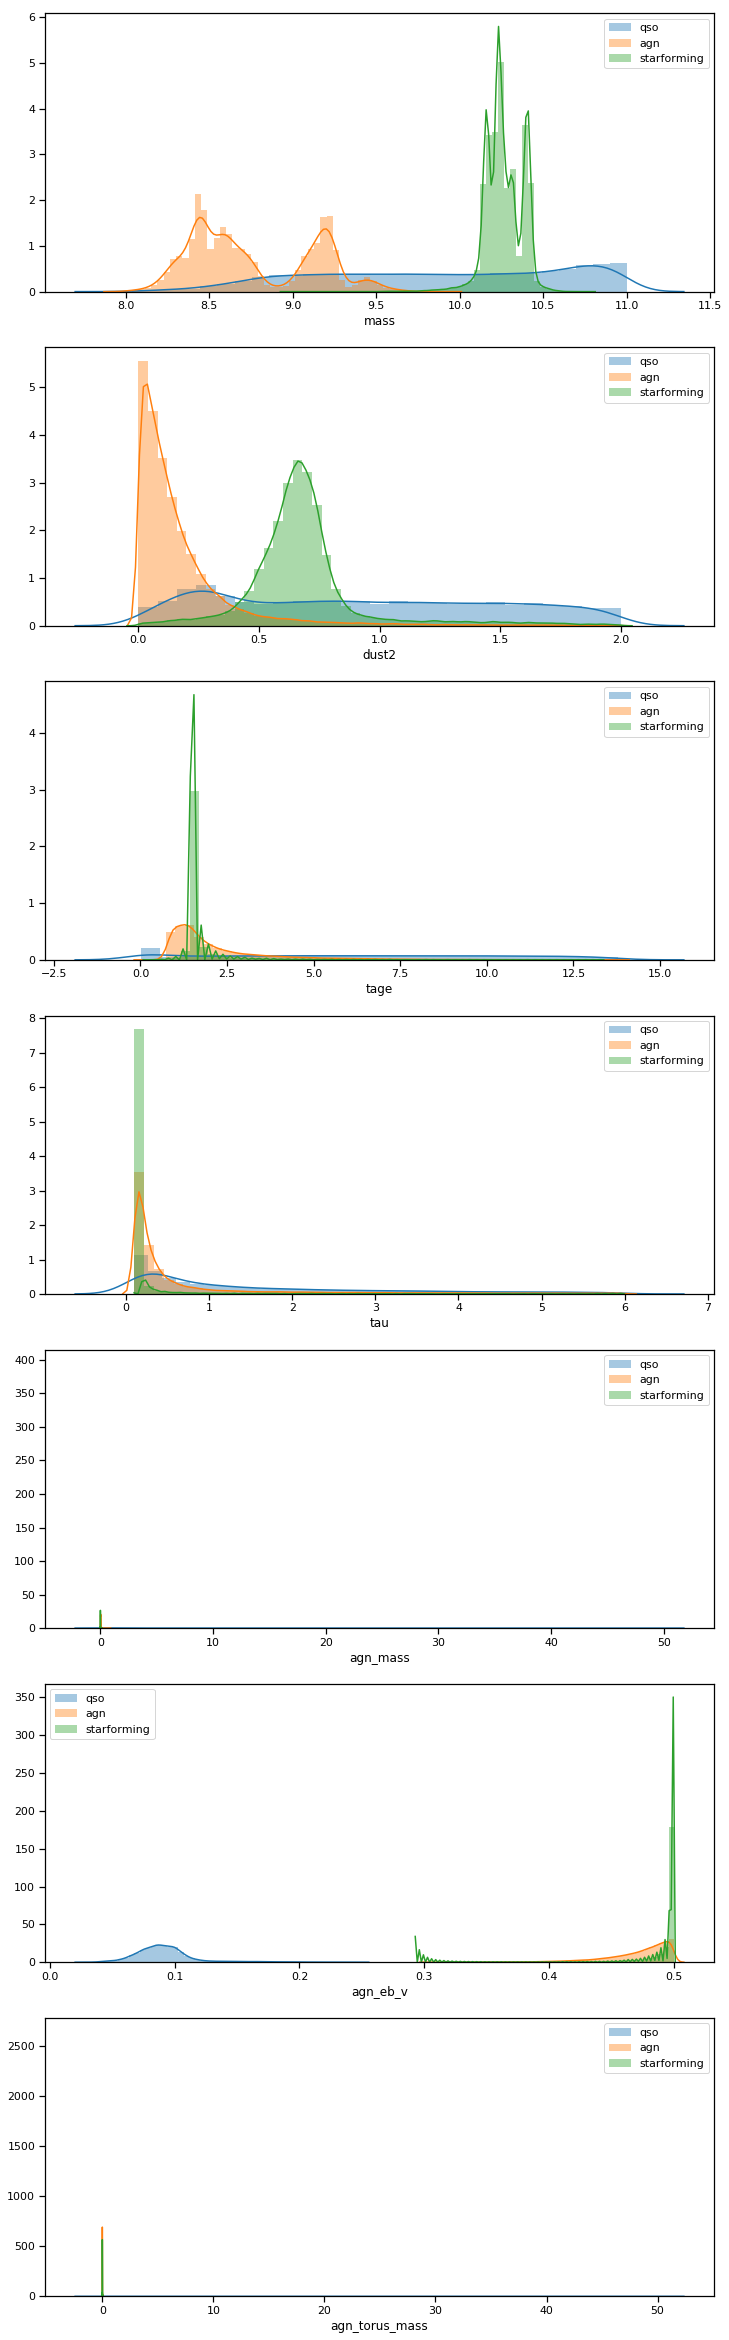

In [14]:
nrows = len(free_params)
fig, axes = plt.subplots(nrows=nrows, figsize=(12, 6 * nrows))
for ax_n, ax in enumerate(axes):
    feature = free_params[ax_n]
    #  _ = sns.catplot(data=df, x='galaxy_class', y=feature, kind="violin", ax=ax)
    for galaxy_class in galaxy_classes:
        values = df[df['galaxy_class'] == galaxy_class][feature]
        if feature in log_params:
            values = np.log10(values)
        sns.distplot(values, label=galaxy_class, ax=ax)
        ax.legend()
#     ax.set_ylim(limits[feature])
# print('done')

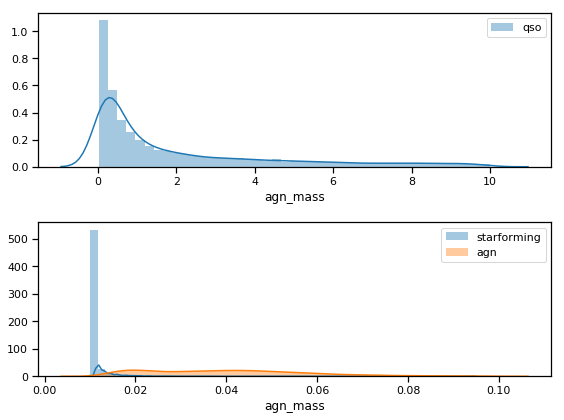

In [15]:
fig, axes = plt.subplots(nrows=2, figsize=(8, 6))
for galaxy_class in ['qso']:
    sns.distplot(df[(df['galaxy_class'] == galaxy_class) & (df['agn_mass'] < 10.)]['agn_mass'], label=galaxy_class, ax=axes[0])
for galaxy_class in ['starforming', 'agn']:
    sns.distplot(df[(df['galaxy_class'] == galaxy_class) & (df['agn_mass'] < .1)]['agn_mass'], label=galaxy_class, ax=axes[1])
axes[0].legend()
axes[1].legend()
fig.tight_layout()

In [16]:
sf = df[df['galaxy_class'] =='starforming']

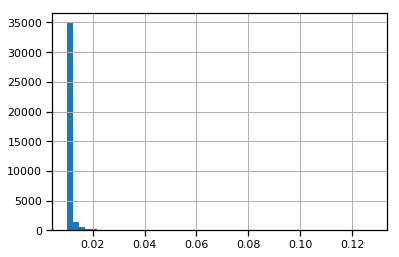

In [19]:
sf['agn_mass'].hist(bins=50)

In [20]:
sf['agn_mass'].median()  # i.e. 1e-3, the minimum

0.010082892

In [21]:
sf['agn_eb_v'].median()  # i.e. 5, the max

0.49875748

In [22]:
sf['agn_torus_mass'].median()  # i.e. 1e-3, the minimum

0.001077342

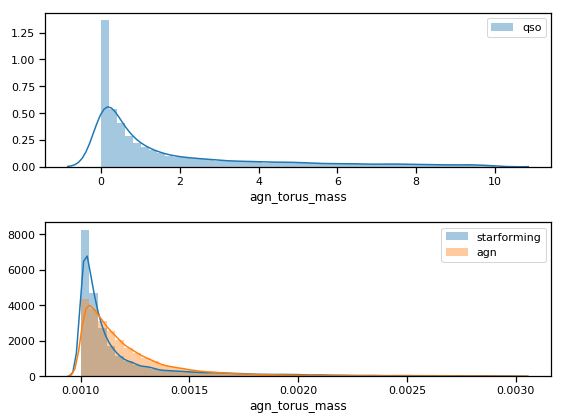

In [17]:
fig, axes = plt.subplots(nrows=2, figsize=(8, 6))
for galaxy_class in ['qso']:
    sns.distplot(df[(df['galaxy_class'] == galaxy_class) & (df['agn_torus_mass'] < 10.)]['agn_torus_mass'], label=galaxy_class, ax=axes[0])
for galaxy_class in ['starforming', 'agn']:
    sns.distplot(df[(df['galaxy_class'] == galaxy_class) & (df['agn_torus_mass'] < .003)]['agn_torus_mass'], label=galaxy_class, ax=axes[1])
axes[0].legend()
axes[1].legend()
fig.tight_layout()